In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%matplotlib inline
from utils.paths import *

import pandas as pd
import matplotlib.pyplot as plt
import os

In [4]:
def get_scores_dataframe(dataset, dims, prefix=""):
    df = None

    for prueba in pruebas:
        path = os.path.join(scores_path, dataset, prueba, "%s%d.csv" % (prefix, dims))
        
        if os.path.exists(path):
            #print path
            if df is None:
                df = pd.read_csv(path, sep=',', header=0)
            else:
                new_df = pd.read_csv(path, sep=',', header=0)
                df = df.append(new_df, ignore_index=True)
    
    if df is None:
        return pd.DataFrame(columns=dataframe_columns)
    
    path_baseline = os.path.join(scores_path, dataset_name, 'baseline', "me2_%d.csv" % dims)
    df_baseline = pd.read_csv(path_baseline, sep=',', header=0)
    

    for por in [25, 50, 100]:
        df2 = df_baseline
        df2['Porcentaje'] = por
        
        df = pd.concat([df, df2], ignore_index=True)

    #se dejan disponibles solamente la tarea, el tipo de adaptacion y el error
    df_a = df[['Adaptacion', 'Tarea', 'Transfer loss', 'Porcentaje']]
    
    # se manipula el dataframe para dejar la adaptacion como columna 
    df_a = df_a.groupby(['Tarea', 'Adaptacion', 'Porcentaje'], as_index=True).max()
    df_a = df_a.unstack(level=1)
    df_a.columns = df_a.columns.levels[1]
    
    return df_a

In [3]:
def get_best_scores_dataframe_all_tests(dataset, dims):
    df = None

    for prueba in pruebas:
        path = os.path.join(scores_path, dataset, prueba, "%s%d.csv" % ("me1_", dims))
        
        if os.path.exists(path):
            #print path
            if df is None:
                df = pd.read_csv(path, sep=',', header=0)
            else:
                new_df = pd.read_csv(path, sep=',', header=0)
                df = df.append(new_df, ignore_index=True)
    
    if df is None:
        return pd.DataFrame(columns=dataframe_columns)
    
    df['Tipo'] = 'M.E. 1'
    
    df2 = None
    for prueba in pruebas:
        path = os.path.join(scores_path, dataset, prueba, "%s%d.csv" % ("me2_", dims))
        
        if os.path.exists(path):
            #print path
            if df2 is None:
                df2 = pd.read_csv(path, sep=',', header=0)
            else:
                new_df2 = pd.read_csv(path, sep=',', header=0)
                df2 = df2.append(new_df2, ignore_index=True)
    
    df2['Tipo'] = 'M.E. 2'
    
    df3 = None
    for prueba in pruebas:
        path = os.path.join(scores_path, dataset, prueba, "%s%d.csv" % ("inductive_", dims))
        
        if os.path.exists(path):
            #print path
            if df3 is None:
                df3 = pd.read_csv(path, sep=',', header=0)
            else:
                new_df3 = pd.read_csv(path, sep=',', header=0)
                df3 = df3.append(new_df3, ignore_index=True)
    
    df3['Tipo'] = df3['Porcentaje']
    
#     df3 = df3[['Adaptacion', 'Tarea', 'Tipo', 'Transfer loss']]
#     df3 = df3.sort_values(['Tarea', 'Transfer loss'], ascending = [True, True])
#     df3 = df3.groupby(['Tarea']).first()
    
    df = pd.concat([df, df2, df3])
    
    #se dejan disponibles solamente la tarea, el tipo de adaptacion y el error
    df_a = df[['Adaptacion', 'Tarea', 'Tipo', 'Transfer loss']]
    df_a = df_a.sort_values(['Tarea', 'Transfer loss'], ascending = [True, True])
#     # se manipula el dataframe para dejar la adaptacion como columna 
    df_a = df_a.groupby(['Tarea']).first()
    
    return df_a

# Dataset Amazon

### Clasificaciones mejoradas y empeoradas

In [5]:
porcentajes = [25, 50, 100]
dim = 3000
prefix = "inductive_"
dataset_name = datasets[0]

df_amazon = get_scores_dataframe(dataset_name, dim, prefix)

In [6]:
df = pd.DataFrame(columns=['Algoritmo', '25 Mejoras', '25 Emp', '50 Mejoras', '50 Emp', '100 Mejoras', '100 Emp'])
j = 0
for i in ['GFK', 'PCA', 'SDA', 'mSDA']:
    lista = [i]
    
    for porc in porcentajes:
        df_temp = df_amazon.xs(porc, level=1)
        
        mejoras =  (df_temp[i] < df_temp.Baseline).sum()
        emp = (df_temp[i] > df_temp.Baseline).sum()
        lista += [mejoras, emp]
    
    df.loc[j] = lista
    j += 1
df

,Algoritmo,25 Mejoras,25 Emp,50 Mejoras,50 Emp,100 Mejoras,100 Emp
0,GFK,12,0,10,2,9,3
1,PCA,9,3,9,3,9,3
2,SDA,10,2,7,5,4,8
3,mSDA,9,3,7,5,5,7


### Mejores resultados

In [7]:
dim = 3000
dataset_name = datasets[0]

df_amazon = get_best_scores_dataframe_all_tests(dataset_name, dim)
#print df_amazon.to_latex(bold_rows=True)
df_amazon

,Adaptacion,Tipo,Transfer loss
Tarea,,,
b->d,GFK,25,-2.261292
b->e,GFK,25,0.079118
b->k,GFK,25,1.693803
d->b,PCA,25,-0.060476
d->e,GFK,50,5.498872
d->k,GFK,25,2.995297
e->b,mSDA,25,4.633788
e->d,GFK,25,1.757106
e->k,PCA,50,-0.958890


In [8]:
df_amazon.Tipo.value_counts()

25    10
50     2
Name: Tipo, dtype: int64

In [9]:
df_amazon.Adaptacion.value_counts()

GFK     8
PCA     3
mSDA    1
Name: Adaptacion, dtype: int64

### Graficos

In [10]:
dim = 3000
prefix = "inductive_"
dataset_name = datasets[0]

df_amazon = get_scores_dataframe(dataset_name, 3000, prefix)
df_amazon1, df_amazon2, df_amazon3, df_amazon4 = df_amazon[:9], df_amazon[9:18], df_amazon[18:27], df_amazon[27:]

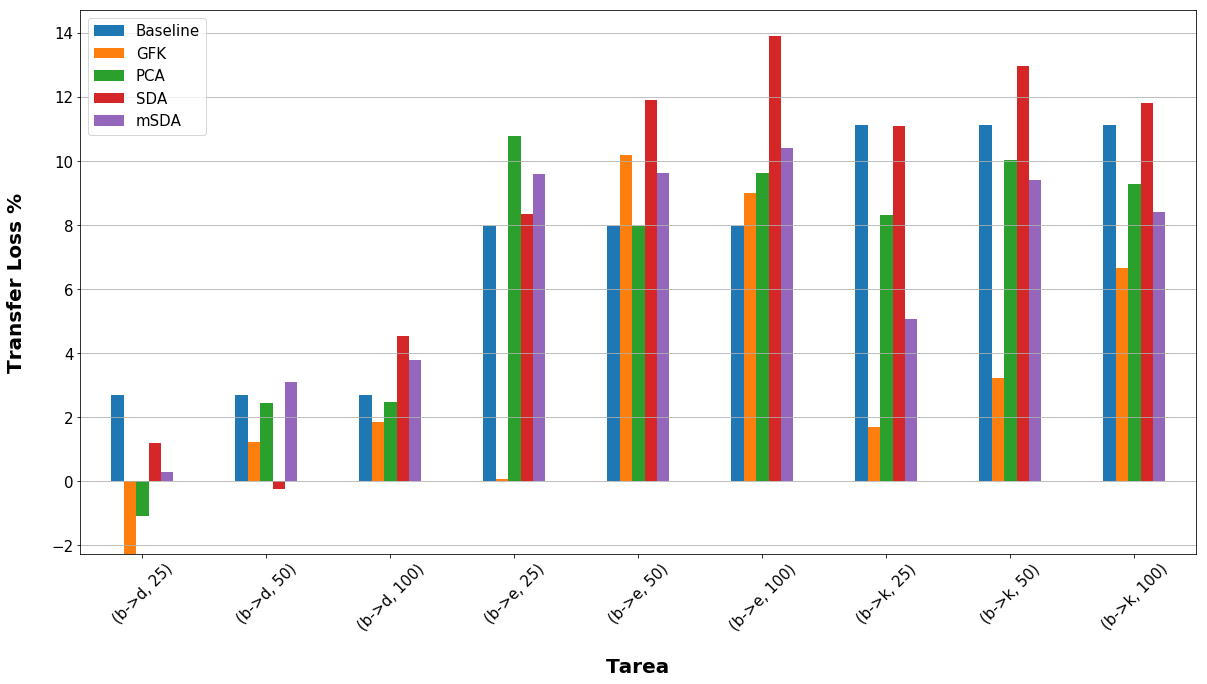

In [11]:
amazon_plot = df_amazon1.plot(kind='bar', figsize=(20,10), rot=45, fontsize=15, legend=False)
patches, labels = amazon_plot.get_legend_handles_labels()

amazon_plot.legend(patches, labels, loc='best', fontsize=15)
amazon_plot.yaxis.grid(which='major')

amazon_plot.set_ylabel("Transfer Loss %", labelpad=25,fontsize=20, weight='bold')
amazon_plot.set_xlabel("Tarea", labelpad=25,fontsize=20, weight='bold')

figure_path = os.path.join(graficos_path, dataset_name, "%stloss_%d_1.eps" % (prefix, dim))
plt.savefig(figure_path, bbox_inches='tight')

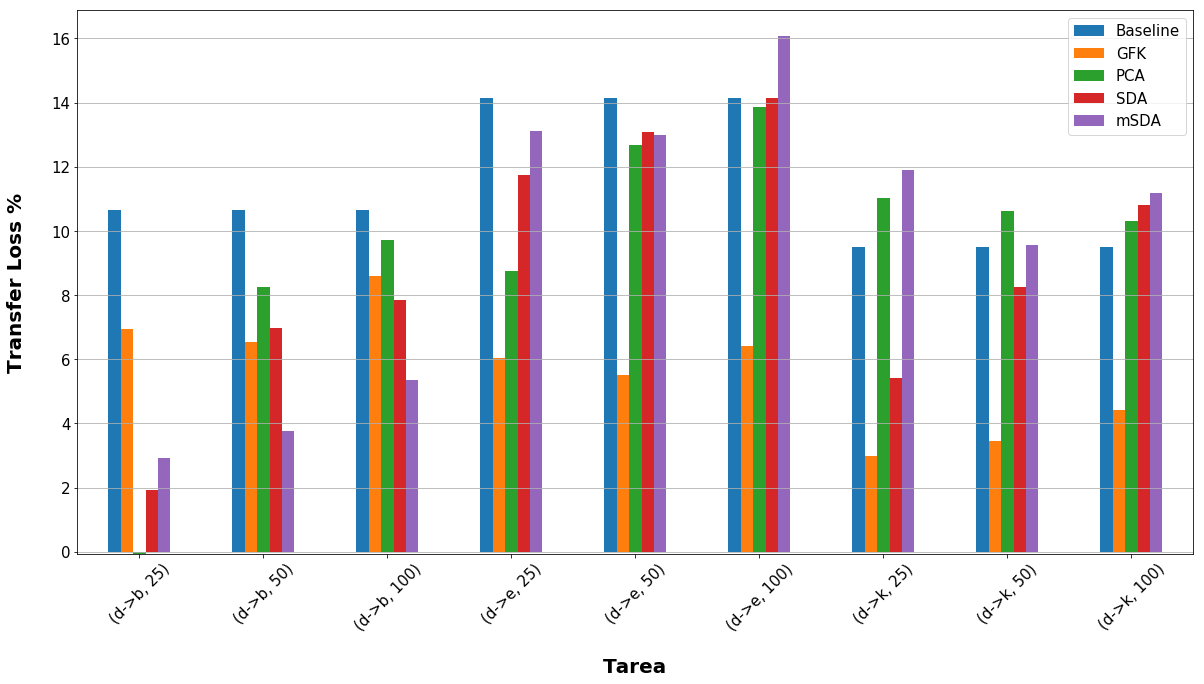

In [12]:
amazon_plot = df_amazon2.plot(kind='bar', figsize=(20,10), rot=45, fontsize=15, legend=False)
patches, labels = amazon_plot.get_legend_handles_labels()

amazon_plot.legend(patches, labels, loc='best', fontsize=15)
amazon_plot.yaxis.grid(which='major')

amazon_plot.set_ylabel("Transfer Loss %", labelpad=25,fontsize=20, weight='bold')
amazon_plot.set_xlabel("Tarea", labelpad=25,fontsize=20, weight='bold')

figure_path = os.path.join(graficos_path, dataset_name, "%stloss_%d_2.eps" % (prefix, dim))
plt.savefig(figure_path, bbox_inches='tight')

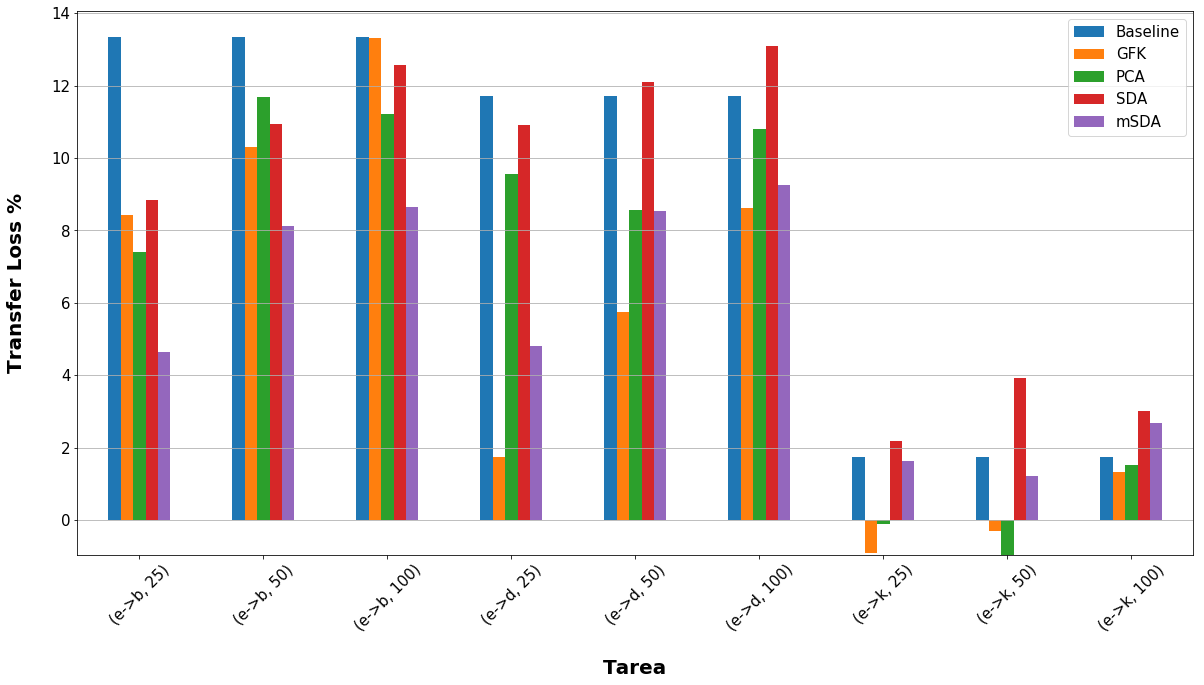

In [13]:
amazon_plot = df_amazon3.plot(kind='bar', figsize=(20,10), rot=45, fontsize=15, legend=False)
patches, labels = amazon_plot.get_legend_handles_labels()

amazon_plot.legend(patches, labels, loc='best', fontsize=15)
amazon_plot.yaxis.grid(which='major')

amazon_plot.set_ylabel("Transfer Loss %", labelpad=25,fontsize=20, weight='bold')
amazon_plot.set_xlabel("Tarea", labelpad=25,fontsize=20, weight='bold')

figure_path = os.path.join(graficos_path, dataset_name, "%stloss_%d_3.eps" % (prefix, dim))
plt.savefig(figure_path, bbox_inches='tight')

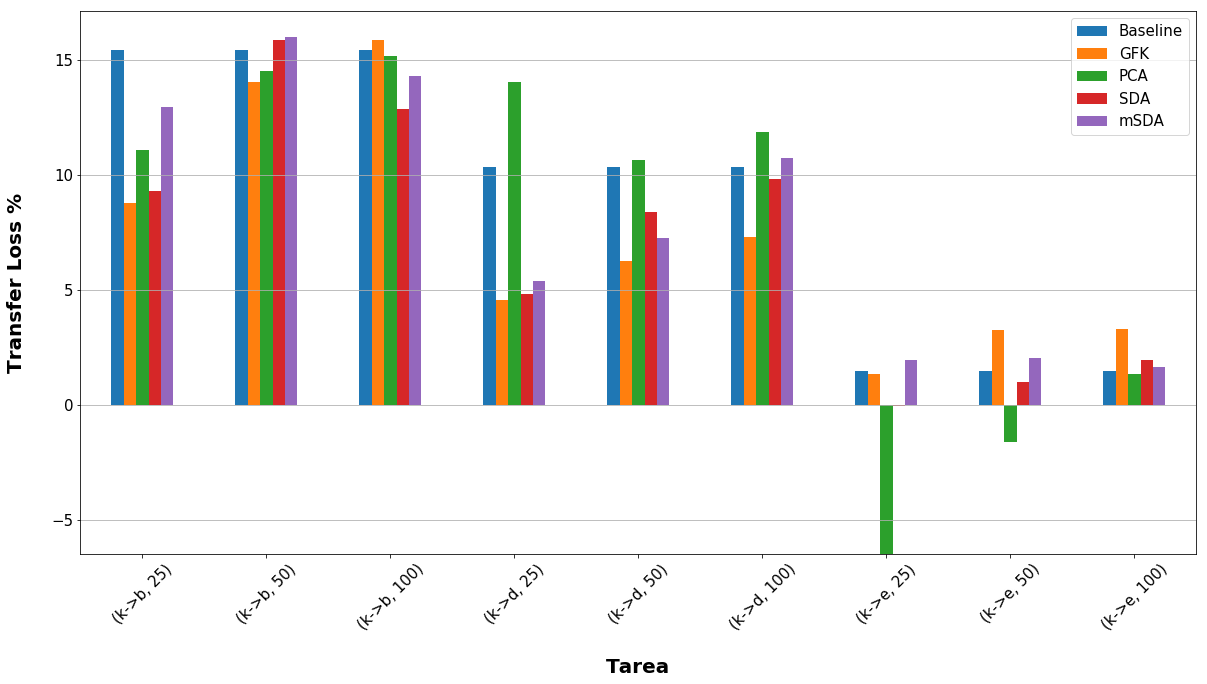

In [14]:
amazon_plot = df_amazon4.plot(kind='bar', figsize=(20,10), rot=45, fontsize=15, legend=False)
patches, labels = amazon_plot.get_legend_handles_labels()

amazon_plot.legend(patches, labels, loc='best', fontsize=15)
amazon_plot.yaxis.grid(which='major')

amazon_plot.set_ylabel("Transfer Loss %", labelpad=25,fontsize=20, weight='bold')
amazon_plot.set_xlabel("Tarea", labelpad=25,fontsize=20, weight='bold')

figure_path = os.path.join(graficos_path, dataset_name, "%stloss_%d_4.eps" % (prefix, dim))
plt.savefig(figure_path, bbox_inches='tight')

## Dataset Twitter

### Clasificaciones mejoradas y empeoradas

In [15]:
porcentajes = [25, 50, 100]
dim = 2000
prefix = "inductive_"
dataset_name = datasets[1]

df_twitter = get_scores_dataframe(dataset_name, dim, prefix)

In [16]:
df = pd.DataFrame(columns=['Algoritmo', '25 Mejoras', '25 Emp', '50 Mejoras', '50 Emp', '100 Mejoras', '100 Emp'])
j = 0
for i in ['GFK', 'PCA', 'SDA', 'mSDA']:
    lista = [i]
    
    for porc in porcentajes:
        df_temp = df_twitter.xs(porc, level=1)
        
        mejoras =  (df_temp[i] < df_temp.Baseline).sum()
        emp = (df_temp[i] > df_temp.Baseline).sum()
        lista += [mejoras, emp]
    
    df.loc[j] = lista
    j += 1
df

,Algoritmo,25 Mejoras,25 Emp,50 Mejoras,50 Emp,100 Mejoras,100 Emp
0,GFK,5,1,5,1,5,1
1,PCA,5,1,6,0,4,1
2,SDA,5,1,5,1,3,2
3,mSDA,6,0,6,0,4,2


### Mejores resultados

In [17]:
dim = 2000
dataset_name = datasets[1]

df_twitter = get_best_scores_dataframe_all_tests(dataset_name, dim)
#print df_amazon.to_latex(bold_rows=True)
df_twitter

,Adaptacion,Tipo,Transfer loss
Tarea,,,
g->r,mSDA,25,-5.579082
g->t,mSDA,25,5.624324
r->g,mSDA,25,11.068779
r->t,SDA,25,-1.480336
t->g,GFK,50,6.723363
t->r,mSDA,25,-10.208711


In [18]:
df_twitter.Tipo.value_counts()

25    5
50    1
Name: Tipo, dtype: int64

In [19]:
df_twitter.Adaptacion.value_counts()

mSDA    4
GFK     1
SDA     1
Name: Adaptacion, dtype: int64

### Graficos

In [20]:
dim = 2000
prefix = "inductive_"
dataset_name = datasets[1]

df_twitter = get_scores_dataframe(dataset_name, 2000, prefix)
df_twitter1, df_twitter2, df_twitter3 = df_twitter[:6], df_twitter[6: 12], df_twitter[12:]

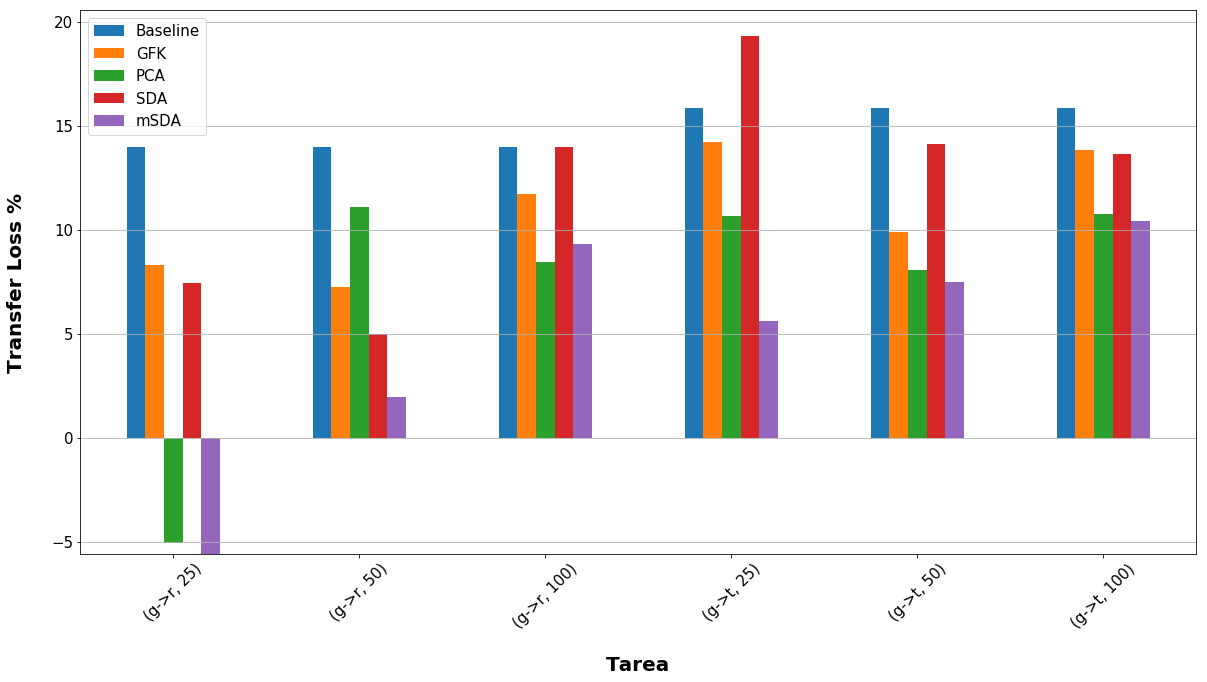

In [21]:
twitter_plot = df_twitter1.plot(kind='bar', figsize=(20,10), rot=45, fontsize=15, legend=False)
patches, labels = twitter_plot.get_legend_handles_labels()

twitter_plot.legend(patches, labels, loc='best', fontsize=15)
twitter_plot.yaxis.grid(which='major')

twitter_plot.set_ylabel("Transfer Loss %", labelpad=25,fontsize=20, weight='bold')
twitter_plot.set_xlabel("Tarea", labelpad=25,fontsize=20, weight='bold')

figure_path = os.path.join(graficos_path, dataset_name, "%stloss_%d_1.eps" % (prefix, dim))
plt.savefig(figure_path, bbox_inches='tight')

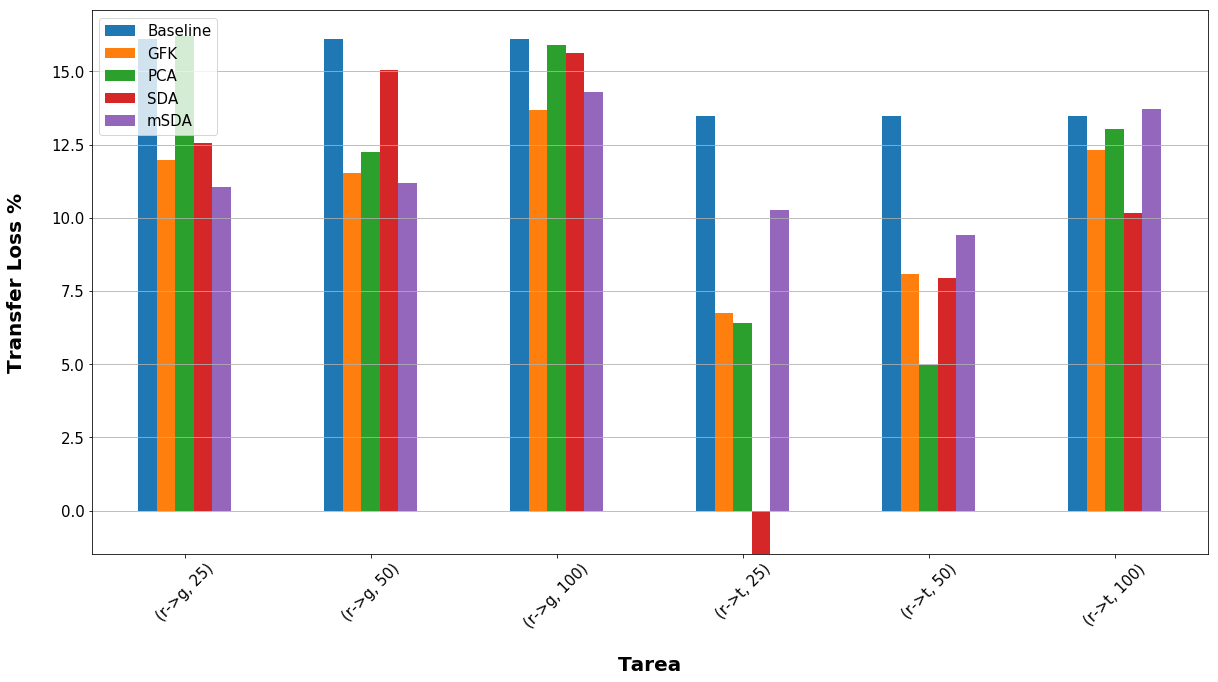

In [22]:
twitter_plot = df_twitter2.plot(kind='bar', figsize=(20,10), rot=45, fontsize=15, legend=False)
patches, labels = twitter_plot.get_legend_handles_labels()

twitter_plot.legend(patches, labels, loc='best', fontsize=15)
twitter_plot.yaxis.grid(which='major')

twitter_plot.set_ylabel("Transfer Loss %", labelpad=25,fontsize=20, weight='bold')
twitter_plot.set_xlabel("Tarea", labelpad=25,fontsize=20, weight='bold')

figure_path = os.path.join(graficos_path, dataset_name, "%stloss_%d_2.eps" % (prefix, dim))
plt.savefig(figure_path, bbox_inches='tight')

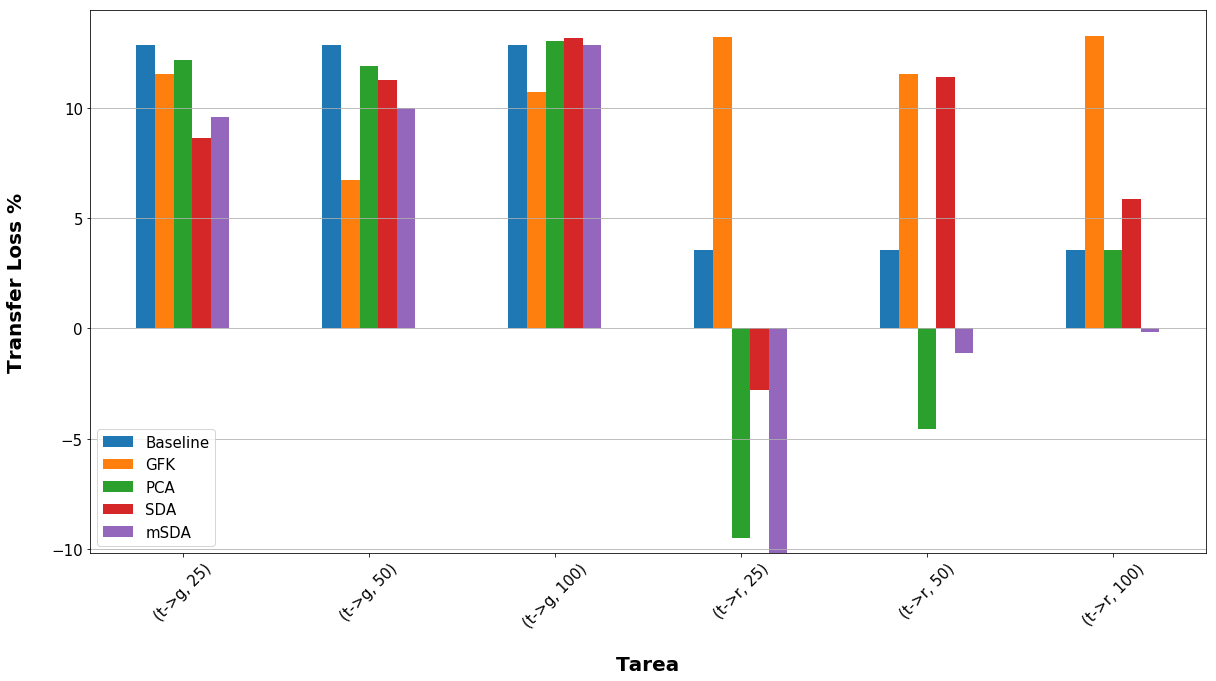

In [23]:
twitter_plot = df_twitter3.plot(kind='bar', figsize=(20,10), rot=45, fontsize=15, legend=False)
patches, labels = twitter_plot.get_legend_handles_labels()

twitter_plot.legend(patches, labels, loc='best', fontsize=15)
twitter_plot.yaxis.grid(which='major')

twitter_plot.set_ylabel("Transfer Loss %", labelpad=25,fontsize=20, weight='bold')
twitter_plot.set_xlabel("Tarea", labelpad=25,fontsize=20, weight='bold')

figure_path = os.path.join(graficos_path, dataset_name, "%stloss_%d_3.eps" % (prefix, dim))
plt.savefig(figure_path, bbox_inches='tight')